# Bootstrapping

Bootstrapping is a statistical technique that allows us to access uncertainty about a certain point estimate. As far as we have seen in the course, whenever we wanted to calculate confidence intervals of an estimate, or calculate its standard errors, we would rely on asymptotic arguments. Those work well when we have large data sets. However, in small sample data sets, those arguments may be weaker and Boostrap methods can be useful. 

Bootstrapping consists in treating the sample we are using for point estimates as the population, so we can have access to uncertainty measures of the point estimates. In general, we would like to have confidence intervals or standard errors from some point estimate, say $\hat{\mu}$, calculated using our main sample of size $N$. To perform a bootstrap, we first have to resample our main sample $M$ times with replacement. For each of these new samples, we can calculate a new point estimate. That is, we will end up with a collection $\{\hat{\mu}^{(1)},\hat{\mu}^{(2)},\dots,\hat{\mu}^{(M)}\}$. This collection of estimates can be treated as a sample from the theoretical distribution of $\hat{\mu}$, so we can calculate it's percentiles to calculate our desired measures of uncertainty.

We can start simple by working with the simple average. Let's generate an i.i.d. sample and calculate the 5 samples average

\begin{equation*}

Y_i \sim U(0,1) 

\end{equation*}

\begin{equation*}

\mu_i = \frac{1}{2}
\quad
\sigma^2_{i} = \frac{1}{12}

\end{equation*}

\begin{equation*}

\bar{Y}=\sum_{i=1}^{5}\frac{Y_i}{5}

\end{equation*}



We can conduct a monte carlo experiment to know with high level of accuracy the small sample properties of this average.

In [208]:
N = 10
MC_reps = 100_000
Y_hat_MC = zeros(MC_reps)

for i in 1:MC_reps
    sample = rand(N)
    Y_hat_MC[i] = mean(sample)
end

lower_bound_MC = quantile(Y_hat_MC, 0.025)
upper_bound_MC = quantile(Y_hat_MC, 0.975)

println(lower_bound_MC)
println(upper_bound_MC)

0.32264811698425083
0.6771644299018822


Now, let's calculate the confidence intervals using asymptotic arguments. Let's take another sample from the distribution and calculate it's average

In [209]:
Y = rand(N)
Y_hat = mean(Y)

0.4328878628340336

By the Central Limit Theorem for i.i.d. samples (Lindeberg-Lévy), the asymptotic distribution of the sample average is 

\begin{equation*}

\bar{Y} \overset{a}{\sim} N\left(\frac{1}{2},\frac{1}{12n}\right)

\end{equation*}

We can use scipy to calculate the 95% confidence interval around the mean

In [210]:
using Distributions

lower_bound = quantile(Normal(1/2, 1/sqrt(12*N)), 0.025)
upper_bound = quantile(Normal(1/2, 1/sqrt(12*N)), 0.975)

0.678919414371716

In [211]:
print(lower_bound)
print(upper_bound)

0.321080585628283840.678919414371716

The results are definitely not accurate

Now, let's calculate the confidence intervals using bootstrap

In [212]:
M = 100_000
Y_hat_boost = zeros(M)

for i in 1:M
    Y_boost = rand(Y, N)  # Bootstrap sampling with replacement
    Y_hat_boost[i] = mean(Y_boost)
end

lower_bound_boost = quantile(Y_hat_boost, 0.025)
upper_bound_boost = quantile(Y_hat_boost, 0.975)

println(lower_bound_boost)
println(upper_bound_boost)

0.2632881435160956
0.6088869598340058


In [213]:
delta = Y_hat_boost .- Y_hat
lower_bound_hall = Y_hat - quantile(delta, 0.975)
upper_bound_hall = Y_hat - quantile(delta, 0.025)

println(lower_bound_hall)
println(upper_bound_hall)

0.2568887658340614
0.6024875821519715


The bootstrap result is fairly more accurate than the asymptotic argument.

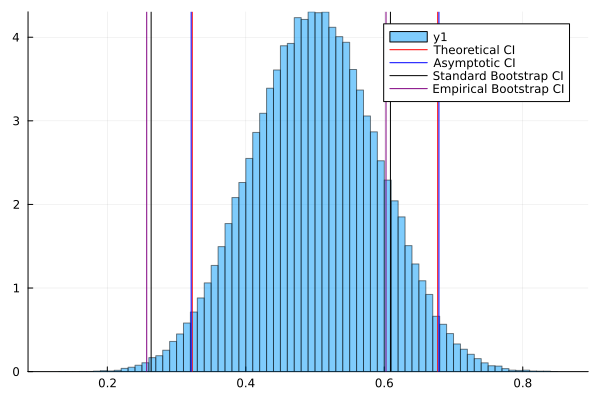

In [214]:
using Plots

# Plotting the histogram
histogram(Y_hat_MC, bins=100, normalize=true, alpha=0.5, legend=:topright)

# Adding the confidence intervals
vline!([lower_bound_MC, upper_bound_MC], color=:red, label="Theoretical CI")
vline!([lower_bound, upper_bound], color=:blue, label="Asymptotic CI")
vline!([lower_bound_boost, upper_bound_boost], color=:black, label="Standard Bootstrap CI")
vline!([lower_bound_hall, upper_bound_hall], color=:purple, label="Empirical Bootstrap CI")

# Display the legend
plot!(legend=:topright)

What about linear regression? We can perform the same task we did with the plain average. For simplicity, let's generate data from a bivariate linear regression:

\begin{equation*}

Y_i = 2+ 3 x_i + \varepsilon_i

\end{equation*}

\begin{equation*}

x_i \sim U(0,1)

\end{equation*}

\begin{equation*}

\varepsilon_i \sim N(0,1)
\end{equation*}

\begin{equation*}

\hat{\beta} = (X^\prime X)^{-1}(X^\prime Y)
\end{equation*}

In [215]:
using Random

# Define parameters
beta_0 = 2
beta_1 = 3
N = 10  # Make sure to define N

# Generate random uniform numbers
x = rand(N)  # This generates N random numbers from a uniform distribution [0, 1)

10-element Vector{Float64}:
 0.35822717316352215
 0.007896503916577036
 0.4261860939681055
 0.423316196248796
 0.3623271440766289
 0.8007575319541457
 0.44975950782580343
 0.10653130220079854
 0.12085246812649109
 0.6040845449682737

Then, we conduct the monte carlo experiment to know with high level of accuracy the small sample properties of this average

In [216]:
using Random
using GLM
using DataFrames

# Parameters
MC_reps = 100_000
N = 10  # Make sure to define N
beta_hat_MC = zeros(MC_reps, 2)

# Loop for Monte Carlo repetitions
for i in 1:MC_reps
    e_MC = randn(N)  # Generate N normal random variables with mean 0 and std 1
    Y_MC = 2 .+ 3 .* x .+ e_MC  # Linear model: Y = 2 + 3x + e_MC
    
    # Fit the linear model
    model_MC = lm(@formula(Y ~ x), DataFrame(Y=Y_MC, x=x))
    
    # Store the coefficients
    beta_hat_MC[i, :] = [coef(model_MC)[1], coef(model_MC)[2]]  # Intercept and slope
end

In [217]:
using Statistics

# Calculate percentiles for b0 and b1
lower_bound_b0_MC = quantile(beta_hat_MC[:, 1], 0.025)  # Note: Julia uses 1-based indexing
upper_bound_b0_MC = quantile(beta_hat_MC[:, 1], 0.975)

lower_bound_b1_MC = quantile(beta_hat_MC[:, 2], 0.025)
upper_bound_b1_MC = quantile(beta_hat_MC[:, 2], 0.975)

# Print results
println("b0")
println(lower_bound_b0_MC)
println(upper_bound_b0_MC)
println("--------------------")
println("b1")
println(lower_bound_b1_MC)
println(upper_bound_b1_MC)

b0
0.8211924856848543
3.167175168496383
--------------------
b1
0.28521730088839153
5.74983421698089


Now, let's calculate the confidence intervals using asymptotic arguments. Let's take another sample from the DGP and estimate the coefficients

In [218]:
using Random
using GLM
using DataFrames

# Define parameters
N = 10  # Make sure to define N
x = rand(N)  # Generate N random uniform values between 0 and 1

# Generate Y
Y = 2 .+ 3 .* x .+ randn(N)  # Y = 2 + 3x + e (where e ~ N(0, 1))

# Fit the linear model
model_hat = lm(@formula(Y ~ x), DataFrame(Y=Y, x=x))

# Store coefficients
beta_hat = [coef(model_hat)[1], coef(model_hat)[2]]  # Intercept and slope

2-element Vector{Float64}:
 2.007230828972846
 2.4556206032084003

By the Central Limit Theorem for linear regression, the asymptotic distribution of the coefficients is

\begin{equation*}

\hat{\beta} \overset{a}{\sim} N\left(\beta,\sigma^2(X^\prime X)^{-1}\right)

\end{equation*}

Where

\begin{equation*}

\sigma^2 = 1

\end{equation*}

\begin{equation*}

\beta = (2,3)^\prime

\end{equation*}

In [219]:
using LinearAlgebra
using Distributions

# Assuming beta_0 and beta_1 have been defined earlier
# Create the design matrix X
X = hcat(ones(N), x)  # Create a matrix with a column of ones and x

# Calculate the covariance matrix of the betas
cov_betas = inv(X' * X)

# Calculate the confidence intervals
lower_bound_b0 = quantile(Normal(beta_0, sqrt(cov_betas[1, 1])), 0.025)
upper_bound_b0 = quantile(Normal(beta_0, sqrt(cov_betas[1, 1])), 0.975)

lower_bound_b1 = quantile(Normal(beta_1, sqrt(cov_betas[2, 2])), 0.025)
upper_bound_b1 = quantile(Normal(beta_1, sqrt(cov_betas[2, 2])), 0.975)

4.82329244233173

In [220]:
println("b0 ols")
println(lower_bound_b0)
println(upper_bound_b0)
println("--------------------")
println("b1 ols")
println(lower_bound_b1)
println(upper_bound_b1)

b0 ols
0.8629961785447393
3.13700382145526
--------------------
b1 ols
1.1767075576682686
4.82329244233173


To perform a bootstrap for linear regression, there exist at least four methods: empirical/paired bootstrap, residual based bootstrap, wild bootstrap and block bootstrap . The first and second methods are the most commonly used when the basic assumptions of OLS hold (Gauss-Markov theorem). The third and four methods tackle the issues arising from heteroskedasticity and serial correlation. We will stick with the first approach due to it's similarity with the simple average procedure.

In [222]:
using Statistics
using GLM  

M = 100_000

beta_hat_boost = zeros(M, 2)  

for i in 1:M  
    Z = hcat(x, Y)  

    random_index = rand(1:N, N)  

    Z_boost = Z[random_index, :]  

    model_boost = lm(@formula(Y ~ x), DataFrame(Y=Z_boost[:,2], x=Z_boost[:,1])) 
    beta_hat_boost[i, :] = coef(model_boost)  
end


lower_bound_b0_boost = quantile(beta_hat_boost[:, 1], 0.025)
upper_bound_b0_boost = quantile(beta_hat_boost[:, 1], 0.975)

lower_bound_b1_boost = quantile(beta_hat_boost[:, 2], 0.025)
upper_bound_b1_boost = quantile(beta_hat_boost[:, 2], 0.975)

# Print the results
println("b0 simple bootstrap")
println(lower_bound_b0_boost)
println(upper_bound_b0_boost)
println("--------------------")
println("b1 simple bootstrap")
println(lower_bound_b1_boost)
println(upper_bound_b1_boost)

b0 simple bootstrap
0.636447165642416
3.2748930676636094
--------------------
b1 simple bootstrap
0.5932508941470535
4.908269188314048


In [223]:
# Calculate deltas
delta_b0 = beta_hat_boost[:, 1] .- beta_hat[1]  
delta_b1 = beta_hat_boost[:, 2] .- beta_hat[2]

# Calculate Hall bootstrap confidence intervals
lower_bound_b0_hall = beta_hat[1] - quantile(delta_b0, 0.975)
upper_bound_b0_hall = beta_hat[1] - quantile(delta_b0, 0.025)

lower_bound_b1_hall = beta_hat[2] - quantile(delta_b1, 0.975)
upper_bound_b1_hall = beta_hat[2] - quantile(delta_b1, 0.025)

# Print the results
println("b0 empirical bootstrap")
println(lower_bound_b0_hall)
println(upper_bound_b0_hall)
println("--------------------")
println("b1 empirical bootstrap")
println(lower_bound_b1_hall)
println(upper_bound_b1_hall)

b0 empirical bootstrap
0.739568590282083
3.378014492303276
--------------------
b1 empirical bootstrap
0.002972018102752827
4.317990312269747


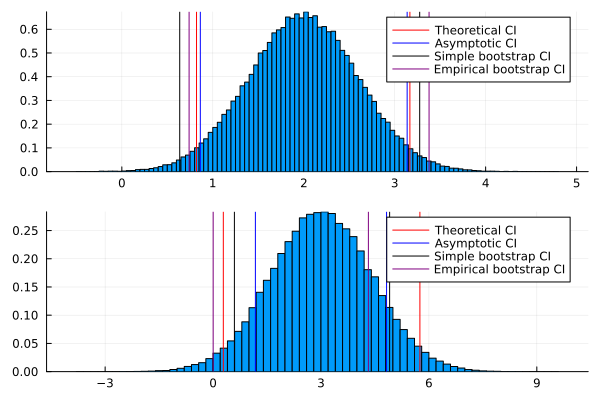

In [224]:
using Plots

# A 2x1 grid for the plots
p = plot(layout = (2, 1))

# Histogram for b0
histogram!(p[1], beta_hat_MC[:, 1], bins=100, normalize=true, label="")

vline!(p[1],[lower_bound_b0_MC, upper_bound_b0_MC], color=:red, label="Theoretical CI")
vline!(p[1],[lower_bound_b0, upper_bound_b0], color=:blue, label="Asymptotic CI")
vline!(p[1],[lower_bound_b0_boost, upper_bound_b0_boost], color=:black, label="Simple bootstrap CI")
vline!(p[1],[lower_bound_b0_hall, upper_bound_b0_hall], color=:purple, label="Empirical bootstrap CI")

# Histogram for b1
histogram!(p[2], beta_hat_MC[:, 2], bins=100, normalize=true, label="")

vline!(p[2],[lower_bound_b1_MC, upper_bound_b1_MC], color=:red, label="Theoretical CI")
vline!(p[2],[lower_bound_b1, upper_bound_b1], color=:blue, label="Asymptotic CI")
vline!(p[2],[lower_bound_b1_boost, upper_bound_b1_boost], color=:black, label="Simple bootstrap CI")
vline!(p[2],[lower_bound_b1_hall, upper_bound_b1_hall], color=:purple, label="Empirical bootstrap CI")

# Show the legends
plot!(p[1], legend=:topright)
plot!(p[2], legend=:topright)

# Display the plots
display(p)
